In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

In [17]:
all_df = pd.read_csv("articles_all.csv")
fraud_df = pd.read_csv("fraud_articles.csv")

print("All articles:", all_df.shape)
print("Fraud-like articles:", fraud_df.shape)

all_df.head()

All articles: (1193, 6)
Fraud-like articles: (308, 6)


,title,url,author,published,summary,similarity
0,Google Ranks Phishing Above Keyloggers & Passw...,https://www.bleepingcomputer.com/news/security...,Catalin Cimpanu,"November 9, 2017",Research carried out by Google engineers and a...,0.607812
1,Highly Sensitive Details of 143 Million Users ...,https://www.bleepingcomputer.com/news/security...,Catalin Cimpanu,"September 8, 2017",Equifax — one of the largest providers of cons...,0.600103
2,"12,449 Data Breaches Confirmed in 2018, a 424%...",https://www.bleepingcomputer.com/news/security...,Sergiu Gatlan,"March 6, 2019",The number of confirmed data breaches during 2...,0.584161
3,Hacker selling 550 million stolen user records...,https://www.bleepingcomputer.com/news/security...,Lawrence Abrams,"May 14, 2020",A threat actor is selling twenty-nine database...,0.571366
4,The password attacks of 2023: Lessons learned ...,https://www.bleepingcomputer.com/news/security...,Home,"December 20, 2023",It should take more than eight characters to b...,0.565341


In [18]:
for df in [all_df, fraud_df]:
    df["published_dt"] = pd.to_datetime(df["published"], errors="coerce")

all_time = all_df.dropna(subset=["published_dt"]).copy()
fraud_time = fraud_df.dropna(subset=["published_dt"]).copy()

In [19]:
all_monthly = (
    all_time
    .set_index("published_dt")
    .resample("M")["url"]
    .count()
    .rename("all_articles")
)

fraud_monthly = (
    fraud_time
    .set_index("published_dt")
    .resample("M")["url"]
    .count()
    .rename("fraud_articles")
)

monthly = pd.concat([all_monthly, fraud_monthly], axis=1).fillna(0)

monthly.tail()

/var/folders/8_/_mkv7dtj7hvfvhvj31qsy35h0000gn/T/ipykernel_90355/1036182284.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["url"]
/var/folders/8_/_mkv7dtj7hvfvhvj31qsy35h0000gn/T/ipykernel_90355/1036182284.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample("M")["url"]


,all_articles,fraud_articles
published_dt,,
2025-07-31,15,1.0
2025-08-31,29,12.0
2025-09-30,16,2.0
2025-10-31,24,6.0
2025-11-30,17,2.0


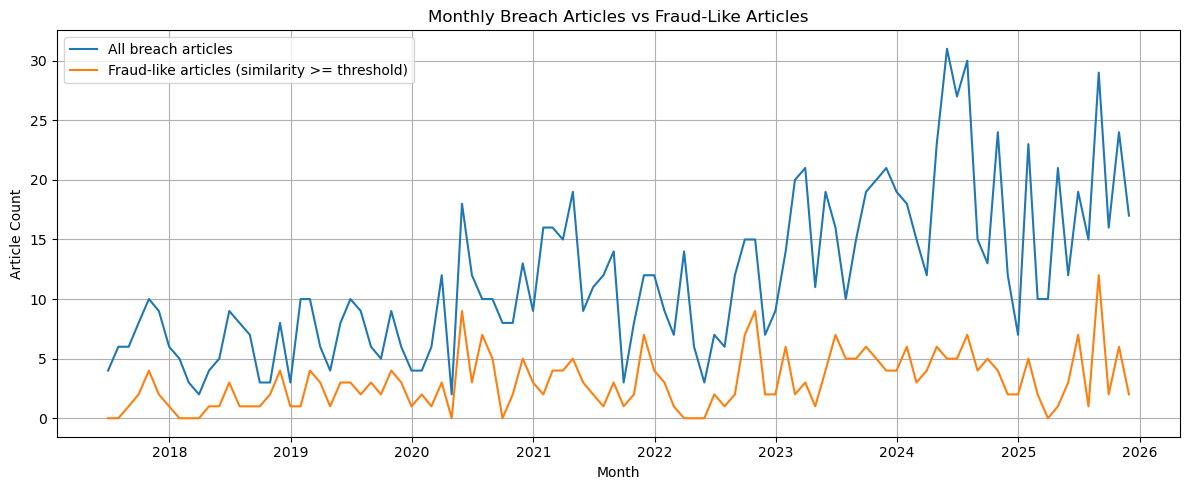

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(monthly.index, monthly["all_articles"], label="All breach articles")
plt.plot(monthly.index, monthly["fraud_articles"], label="Fraud-like articles (similarity >= threshold)")
plt.title("Monthly Breach Articles vs Fraud-Like Articles")
plt.xlabel("Month")
plt.ylabel("Article Count")
plt.legend()
plt.tight_layout()
plt.show()


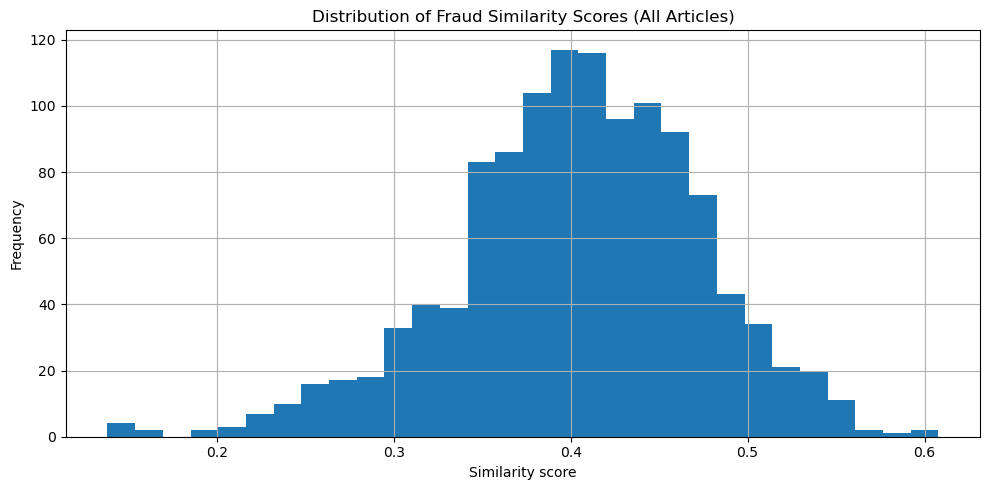

In [21]:
plt.figure(figsize=(10, 5))
all_df["similarity"].hist(bins=30)
plt.title("Distribution of Fraud Similarity Scores (All Articles)")
plt.xlabel("Similarity score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [22]:
top_authors = (
    fraud_df["author"]
    .fillna("unknown")
    .replace("", "unknown")
    .value_counts()
    .head(10)
)

top_authors

author
Lawrence Abrams    94
Sergiu Gatlan      88
Bill Toulas        82
Ionut Ilascu       18
Catalin Cimpanu    16
Home                6
Ax Sharma           4
Name: count, dtype: int64

In [23]:
FRAUD_LEXICON = [
    "ransomware", "phishing", "data leak", "exposed",
    "credential", "extortion", "identity theft",
    "malware", "breach", "exfiltration"
]

fraud_df["summary_lc"] = fraud_df["summary"].fillna("").str.lower()

keyword_counts = {}
total_docs = len(fraud_df)

for kw in FRAUD_LEXICON:
    keyword_counts[kw] = fraud_df["summary_lc"].str.contains(kw).sum()

keyword_share = (
    pd.Series(keyword_counts)
    .sort_values(ascending=False)
    .to_frame("count")
)
keyword_share["share_pct"] = 100 * keyword_share["count"] / total_docs

keyword_share

,count,share_pct
breach,307,99.675325
exposed,206,66.883117
credential,138,44.805195
ransomware,129,41.883117
phishing,112,36.363636
data leak,68,22.077922
identity theft,67,21.753247
extortion,49,15.909091
malware,35,11.363636
exfiltration,7,2.272727


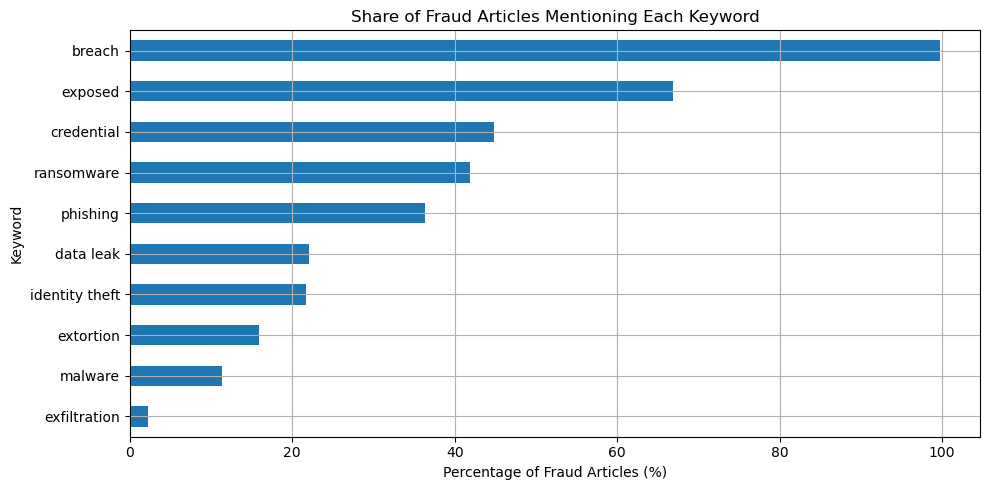

In [24]:
plt.figure(figsize=(10, 5))
keyword_share["share_pct"].sort_values().plot(kind="barh")
plt.title("Share of Fraud Articles Mentioning Each Keyword")
plt.xlabel("Percentage of Fraud Articles (%)")
plt.ylabel("Keyword")
plt.tight_layout()
plt.show()

In [25]:
texts = fraud_df["summary"].fillna("").tolist()

vec = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(2, 3),
    min_df=3,
    max_features=5000
)
X = vec.fit_transform(texts)
scores = np.asarray(X.mean(axis=0)).ravel()
terms = np.array(vec.get_feature_names_out())

top_k = 10 if len(terms) >= 10 else len(terms)
top_idx = scores.argsort()[::-1][:top_k]
top_terms = terms[top_idx]
top_vals = scores[top_idx]

pd.DataFrame({"phrase": top_terms, "score": top_vals})


,phrase,score
0,data breach,0.110058
1,threat actor,0.027272
2,threat actors,0.025865
3,personal information,0.024992
4,ransomware attack,0.019074
5,credit card,0.018961
6,credential stuffing,0.018787
7,stolen data,0.018263
8,email addresses,0.018046
9,cheat sheet,0.017358


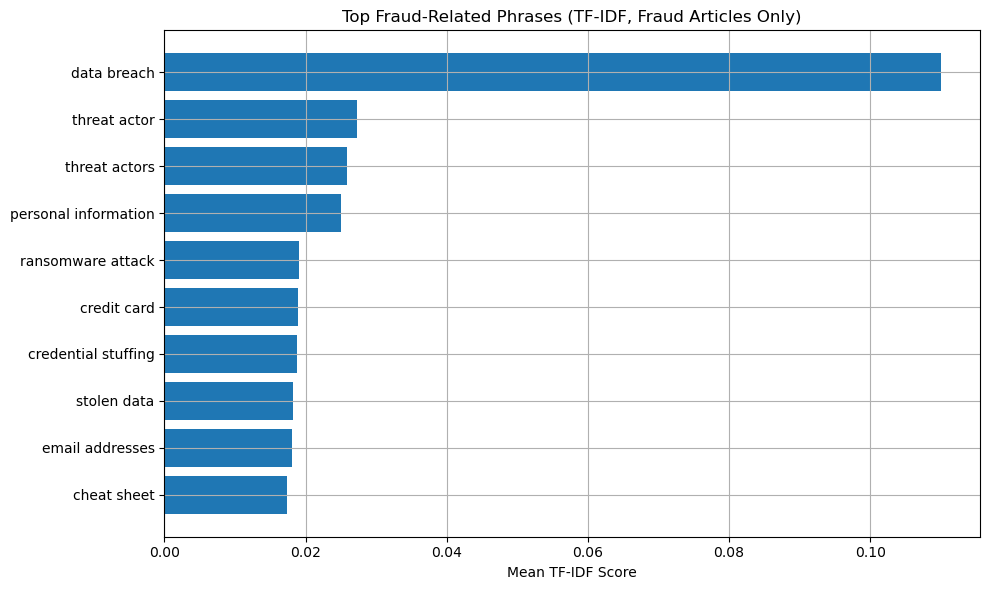

In [26]:
plt.figure(figsize=(10, 6))
y = np.arange(len(top_terms))[::-1]
plt.barh(y, top_vals)
plt.yticks(y, top_terms)
plt.title("Top Fraud-Related Phrases (TF-IDF, Fraud Articles Only)")
plt.xlabel("Mean TF-IDF Score")
plt.tight_layout()
plt.show()


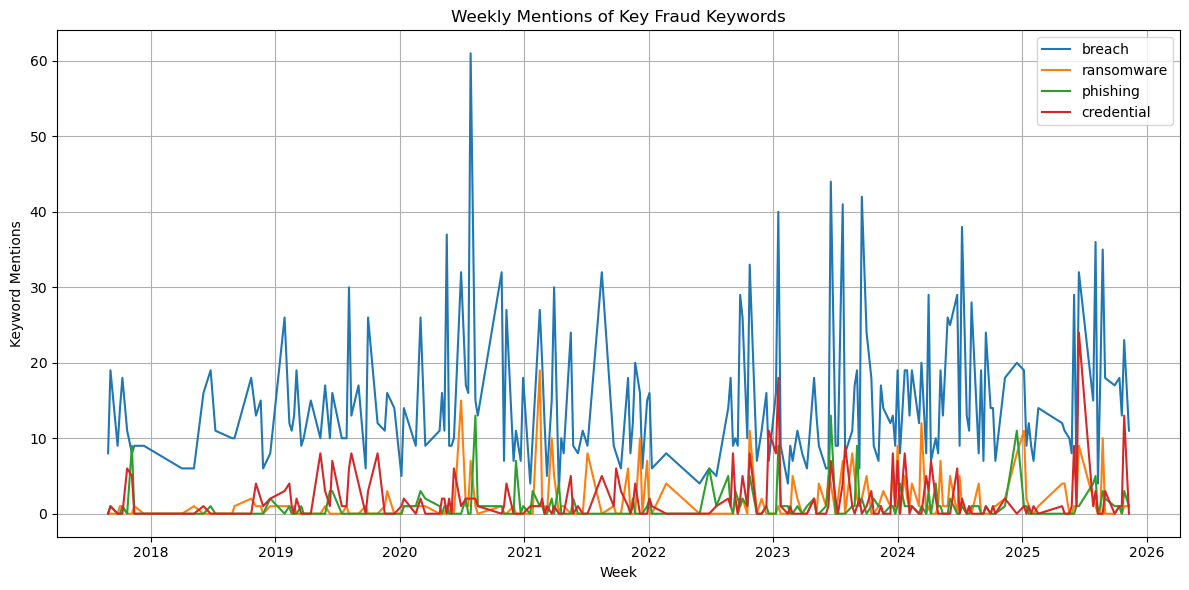

In [27]:
fraud_time = fraud_df.dropna(subset=["published_dt"]).copy()
fraud_time["week"] = fraud_time["published_dt"].dt.to_period("W").dt.start_time
fraud_time["summary_lc"] = fraud_time["summary"].fillna("").str.lower()

rows = []
for week, grp in fraud_time.groupby("week"):
    text = " ".join(grp["summary_lc"].tolist())
    counts = {kw: text.count(kw) for kw in FRAUD_LEXICON}
    counts["week"] = week
    rows.append(counts)

trend_df = pd.DataFrame(rows).sort_values("week")
trend_df.head()

focus_terms = ["breach", "ransomware", "phishing", "credential"]

plt.figure(figsize=(12, 6))
for kw in focus_terms:
    if kw in trend_df.columns:
        plt.plot(trend_df["week"], trend_df[kw], label=kw)

plt.title("Weekly Mentions of Key Fraud Keywords")
plt.xlabel("Week")
plt.ylabel("Keyword Mentions")
plt.legend()
plt.tight_layout()
plt.show()


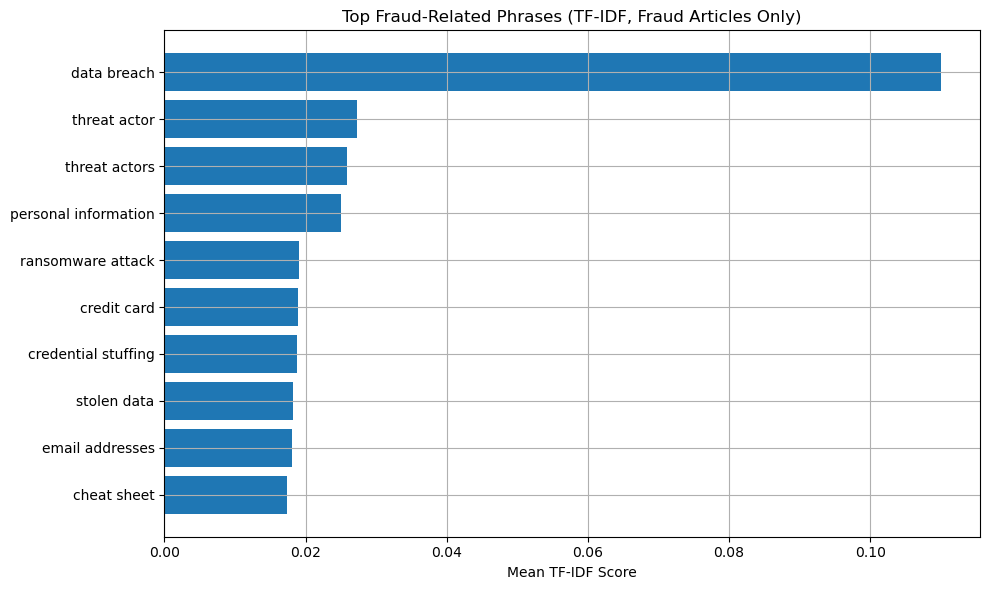

In [28]:
df = pd.read_csv("fraud_articles.csv")

# Clean summaries
texts = df["summary"].fillna("").tolist()

# -------------------------------------
# Build TF-IDF on 2–3 word phrases
# -------------------------------------
vec = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(2, 3),   # <-- Only 2–3 word phrases
    min_df=3,             # <-- Ignore phrases that appear < 3 docs
    max_features=5000
)

X = vec.fit_transform(texts)
scores = np.asarray(X.mean(axis=0)).ravel()
terms = np.array(vec.get_feature_names_out())

# -------------------------------------
# Select top 10 TF-IDF phrases
# -------------------------------------
top_k = 10
top_idx = scores.argsort()[::-1][:top_k]
top_terms = terms[top_idx]
top_vals = scores[top_idx]

# -------------------------------------
# Plot
# -------------------------------------
plt.figure(figsize=(10, 6))
y = np.arange(len(top_terms))[::-1]

plt.barh(y, top_vals)
plt.yticks(y, top_terms)
plt.xlabel("Mean TF-IDF Score")
plt.title("Top Fraud-Related Phrases (TF-IDF, Fraud Articles Only)")

plt.tight_layout()
plt.savefig("top_phrases.png", dpi=150)
plt.show()

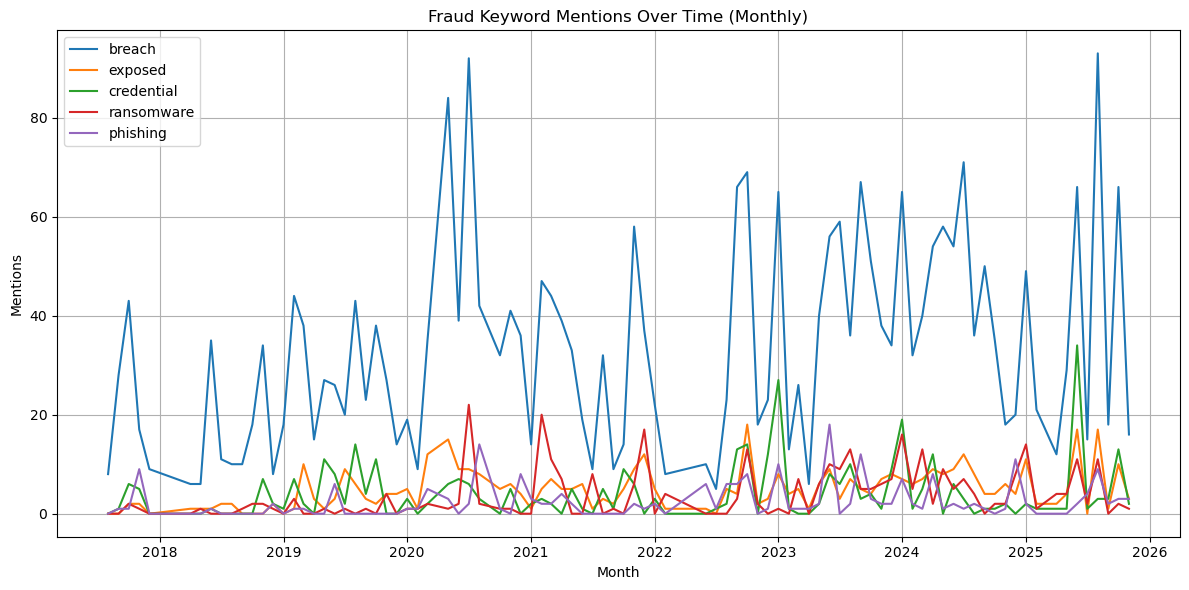

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1. Load fraud-only data
# -------------------------
df = pd.read_csv("fraud_articles.csv")

# parse dates
df["published_dt"] = pd.to_datetime(df["published"], errors="coerce")
df = df.dropna(subset=["published_dt"]).copy()

# lowercase summaries
df["summary_lc"] = df["summary"].fillna("").str.lower()

# define fraud keywords
FRAUD_LEXICON = [
    "breach",
    "exposed",
    "credential",
    "ransomware",
    "phishing",
    "data leak",
    "identity theft",
    "extortion",
    "malware",
    "exfiltration",
]

# -------------------------
# 2. Aggregate by MONTH
# -------------------------
df["month"] = df["published_dt"].dt.to_period("M").dt.start_time

rows = []
for month, grp in df.groupby("month"):
    text = " ".join(grp["summary_lc"].tolist())
    counts = {kw: text.count(kw) for kw in FRAUD_LEXICON}
    counts["month"] = month
    rows.append(counts)

trend_df = pd.DataFrame(rows).sort_values("month")

# -------------------------
# 3. Find top keywords to plot (top 5 by total mentions)
# -------------------------
totals = trend_df.drop(columns=["month"]).sum().sort_values(ascending=False)
keep = totals.head(5).index.tolist()

# -------------------------
# 4. Plot monthly keyword trends
# -------------------------
plt.figure(figsize=(12, 6))
for kw in keep:
    plt.plot(trend_df["month"], trend_df[kw], label=kw)

plt.title("Fraud Keyword Mentions Over Time (Monthly)")
plt.xlabel("Month")
plt.ylabel("Mentions")
plt.legend()
plt.tight_layout()
plt.savefig("keyword_trends_monthly.png", dpi=150)
plt.show()
